In [1]:
import cv2
import numpy as np
import pandas as pd
from glob import glob
from tqdm.auto import tqdm
from sklearn.metrics import *
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import EfficientNetV2B2
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from sklearn.model_selection import train_test_split
import os
import json
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import math
import collections
import random
import numpy as np
import os
from PIL import Image
import time
import random
from keras import backend as K
import pathlib
from sklearn.neighbors import NearestNeighbors

%matplotlib inline
from IPython.display import clear_output

In [2]:
seed = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_everything(seed)

# Загрузка данных

## Загрузка названий фотографий

In [3]:
train_captions = pd.read_csv('data/train.csv').set_index('idx')
train_captions.head()

,item_nm
idx,
7062,Кольцо уплотнительное шарикового подшипника
7203,Корпус подшипника
35,Кран гидравлический замедлительный М18/М18
7023,Труба K-Flex ST 13х22 (2м)
430,Болт M12x30 Kuhn


## Обработка названий, формирование классов

In [4]:
import nltk
import pymorphy2
from wordcloud import WordCloud
import razdel
from string import punctuation

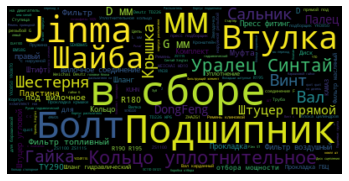

In [5]:
# Create full word text
full_text = ' '
for desc in train_captions.item_nm.values:
    full_text = full_text + ' ' + desc

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50).generate(full_text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [209]:
nltk.download('stopwords') # скачиваем стоп-слова
ru_stopwords = nltk.corpus.stopwords.words('russian')
stop_words = ['...', 'cbn-быть', 'камаз-евро', 'верхний','высокий','г-образный','жёлтый','зелёный',
              'красный','левый','синий','наружный','неподвижный','передний','п-образный','правый', 'т-смарт', 'т-flex',
             'уралец', 'маз', 'камаз', 'медный', 'металлический', 'люкс', 'лобовой', 'коммунальный', 'вс-т', 'влево', 'вправо',
             'задний', 'передний', 'ведущий', 'ведомый', 'болгария', 'греция', 'боковой', 'кабинный', 'азотировать', 'аналог',
             'замедлительный', 'ямз', 'мом', 'торможение', 'прямой', 'простой', 'проходной', 'синтая', 'призматический', 
             'тупой', 'упираться', 'самоустанавливаться', 'радиальный', 'шариковый', 'плунжерный', 'подъёмный', 'трактор',
             'раструбный', 'раструструбный', 'подвижный', 'русич', 'мпа', 'торцевой', 'лодочный', 'четверной', 'универсальный',
             'ход', 'оцинк', 'стопорный', 'круглый', 'сечение', 'квадрат', 'цвет', 'накал', 'нижний', 'верхний', 'солнечный',
             'конический', 'файтереть', 'номерной', 'рубашка', 'сцепление', 'давление', 'поворотный', 'рулевой', 'гладкий', 
             'сталь', 'нержавеющий', 'поворот', 'меш', 'всасывать', 'червячный', 'регулировочный', 'сельскохозяйственный', 
             'пку', 'профильный', 'повышать', 'понижать', 'шаровыя', 'распределительный', 'промежуточный', 'первичный', 
             'бульдозерный', 'ротационный', 'проч', 'пенька', 'ниточный', 'впускной', 'закалённый', 'мотоблок', 'голый', 'клапанный',
             'новый', 'капот', 'штанга', 'цифровой', 'стремянка', 'секция', 'электрический', 'тарелка', 'резьбовой', 'скаут',
             'универсал', 'сменный', 'средний', 'подключение', 'площадка', 'наружний', 'продольный', 'модификация', 'сетка', 
             'стрельчатый', 'прерывание', 'непрерывный', 'ходовой', 'приводной', 'средний', 'реверсивный', 'соединительный',
             'кпс', 'ксп', 'стык', 'отверстый', 'маслосъёмный', 'раздвижной', 'предохранительный', 'тарелка', 'тсн', 'подогрев',
             'хранение', 'урал', 'охлаждать', 'полевой', 'уралец', 'сеновязальный', 'джутовый', 'внешний', 'стальной', 'грубый',
             'система', 'ожлаждение', 'коса', 'напорный', 'дистанционный', 'крестовидный', 'гидравлический', 'дизельный',
             'двойной', 'толщина', 'жечь', 'крестовина', 'имбусовый', 'байонетный', 'навесный', 'усиленный', 'разбрасывать',
             'жсу', 'год', 'мех', 'большой', 'малый', 'резьба', 'переходной', 'бум', 'бумажный', 'маслоналивной', 'плоский',
             'внешний', 'внешн', 'грубый', 'серия', 'распорный', 'стальной', 'бумага', 'подрулевой', 'внутренний', 'раздаточный',
             'роликовый', 'квт', 'градус', 'бобина', 'тонкий', 'зил', 'линейный', 'прозрачный', 'короткий', 'форкамерный']
morph = pymorphy2.MorphAnalyzer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Strix\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [210]:
def preproc(sentence):
    if 'Втулка' in sentence:
        sentence += ' Втулка'
    if 'Пластина' in sentence:
        sentence += ' Пластина'
    tokens = [_.text.lower() for _ in list(razdel.tokenize(str(sentence)))]
    unique_tokens = set()

    final_sentence = []

    for token in tokens:
        if len(token) > 2 and not any([char.isdigit() for char in token]):
            parsed_token = morph.parse(token)[0]
            if str(parsed_token.tag) != 'LATN' \
            and parsed_token.normal_form not in ru_stopwords and parsed_token.normal_form not in punctuation \
            and parsed_token.normal_form not in stop_words:
                
                token = str(parsed_token.normal_form)
                if token in ['u-болт', 'болт-скоба']:
                    token = 'болт'
                elif token == 'гидробак':
                    token = 'бак'
                elif token == 'полуось':
                    token = 'ось'
                elif token == 'проводы':
                    token = 'провод'
                elif token == 'фильтровать':
                    token = 'фильтр'
                elif 'пресс' in token:
                    token = 'пресс'
                elif 'хладон' in token:
                    token = 'баллон'
                elif 'поршневой' in token:
                    token = 'поршень'
                elif 'гайка' in token:
                    token = 'гайка'
                elif 'фреон' in token:
                    token = 'газ'
                elif 'трактор' in token:
                    token = 'трактор'
                elif 'датчик' in token:
                    token = 'датчик'
                elif 'ремкомплект' in token:
                    token = 'ремень'
                elif 'упак' in token:
                    token = 'упаковка'
                elif 'переходный' in token:
                    token = 'переходник'
                elif 'упл' in token:
                    token = 'уплотнитель'
                elif 'компл' in token:
                    token = 'комплект'
                elif 'стартер' in token:
                    token = 'стартер'
                elif 'шатунно-поршневой' in token:
                    token = 'шатун'
                elif 'форсунка-распылитель' in token:
                    token = 'форсунка'
                elif 'фиттинг' in token:
                    token = 'фитинг'
                elif 'всасывать' in token:
                    token = 'вентилятор'
                elif 'валик' in token:
                    token = 'вал'
                elif 'агретирование' in token:
                    token = 'навеска'
                elif 'агрегатирование' in token:
                    token = 'навеска'
                elif 'гидронасос' in token:
                    token = 'гидравлический насос'
                elif 'шарикоподшипник' in token:
                    token = 'подшипник'
                elif 'ролик-натяжитель' in token:
                    token = 'ролик натяжитель'
                    
                if token not in unique_tokens:
                    final_sentence.append(token)
                    unique_tokens.add(token)
    
    # цикл постобработки для уменьшения классов
    if final_sentence:
        final_sentence = final_sentence[:4]
        if 'прокладка' in final_sentence:
            final_sentence = ['прокладка']
        
        if len(final_sentence) >= 2 and final_sentence[-1] == 'зуб':
            final_sentence = final_sentence[:-1]
        if len(final_sentence) > 1 and final_sentence[1] == 'противоскольжение':
            final_sentence = [final_sentence[1]]
        if len(final_sentence) > 1 and final_sentence[1] == 'винт':
            final_sentence = [final_sentence[1]]
        if len(final_sentence) > 1 and final_sentence[1] == 'крепление':
            final_sentence = [final_sentence[1]]
        if len(final_sentence) > 1 and final_sentence[1] == 'вентилятор':
            final_sentence = [final_sentence[1]]
        if len(final_sentence) > 1 and final_sentence[1] == 'зажигание':
            final_sentence = [final_sentence[1]]
        if len(final_sentence) > 1 and final_sentence[1] == 'фара':
            final_sentence = [final_sentence[1]]
        if len(final_sentence) > 1 and final_sentence[1] == 'шланг':
            final_sentence = [final_sentence[1]]
        if len(final_sentence) > 1 and final_sentence[1] == 'штуцер':
            final_sentence = [final_sentence[1]]
        if len(final_sentence) > 1 and final_sentence[1] == 'лемех':
            final_sentence = [final_sentence[1]]
        if len(final_sentence) > 1 and final_sentence[1] == 'форсунка':
            final_sentence = [final_sentence[1]]
        if len(final_sentence) > 1 and final_sentence[1] == 'управление':
            final_sentence = [final_sentence[1]]
        if len(final_sentence) > 1 and final_sentence[1] == 'предохранитель':
            final_sentence = [final_sentence[1]]
        if len(final_sentence) > 1 and final_sentence[1] == 'сальник':
            final_sentence = [final_sentence[1]]
        if len(final_sentence) > 1 and final_sentence[1] == 'уплотнение':
            final_sentence = [final_sentence[1]]
        if len(final_sentence) > 1 and final_sentence[1] == 'нож' and final_sentence[0] == 'вал':
            final_sentence = ['вал_нож']
        if len(final_sentence) > 1 and final_sentence[1] == 'нож':
            final_sentence = [final_sentence[1]]
        
        if final_sentence[0] in ['звёздочка', 'амортизатор', 'болт', 'гайка', 'стекло', 'манометр', 'бак', 'лезвие', 'насос',
                                'лапа', 'сальник', 'свеча', 'сателлит', 'средство', 'фреон', 'ступица', 'топливопровод', 
                                 'тнвда', 'цепь', 'шайба', 'шестерня', 'шпилька', 'штуцер', 'щуп', 'шток', 'шкив', 'шатун',
                                'фонарь', 'фара', 'уплотнение', 'тэн', 'трубка', 'труба', 'стойка', 'скоба',
                                'рычаг', 'ремень', 'реле', 'пружина', 'пресс', 'подшипник', 'пластина', 'палец', 'пара',
                                'опора', 'наконечник', 'мембрана', 'лемех', 'крышка', 'вентиль', 'кран', 'вилка', 'балка',
                                'барабан', 'датчик', 'вентилятор', 'глушитель', 'гидроцилиндр', 'гидрораспределитель', 'диск',
                                'зуб', 'камера', 'клапан', 'коленвал', 'колонка', 'кольцо', 'корзина', 'патрубок', 'покрышка',
                                'пыльник', 'указатель', 'шланг', 'шарнир', 'фланец', 'узел', 'трактор', 'термометр', 
                                 'ролик-натяжитель', 'помпа', 'отвал', 'нож', 'муфта', 'крестовина', 'корпус', 'колесо',
                                'ковш', 'зеркало', 'заглушка', 'держатель', 'габарит', 'втулка', 'винт', 'вилы', 'вальцовка',
                                'вал', 'вкладыш', 'вставка', 'дифференциал', 'зажим', 'коллектор', 'колено', 'ось', 'тарелка',
                                'шплинт', 'форсунка', 'устройство', 'распылитель', 'клин', 'колодка', 'крепление', 'навеска',
                                'поршень', 'радиатор', 'шпонка', 'фитинг', 'тяга', 'сочник', 'рукоятка', 'кронштейн', 'плита',
                                'сошник', 'уплотнитель', 'редуктор', 'замок', 'зип', 'сцепление', 'хомут', 'круг', 'режущий',
                                'припой', 'поршень', 'плунжерный', 'переходник', 'отсечный', 'молоток', 'маховик', 'масло',
                                'кулачок', 'крыльчатка', 'газ', 'фильтр']:
            final_sentence = [final_sentence[0]]
            
        if final_sentence[0] == 'звено':
            final_sentence = ['цепь']
        if final_sentence[-1] == 'штуцер':
            final_sentence = ['штуцер']
        if len(final_sentence) > 1 and final_sentence[1] == 'втулка':
            final_sentence = [final_sentence[1]]
        if len(final_sentence) > 1 and final_sentence[1] == 'клапан':
            final_sentence = [final_sentence[1]]
        if len(final_sentence) > 1 and final_sentence[1] == 'уплотнитель':
            final_sentence = [final_sentence[1]]
        if len(final_sentence) > 1 and final_sentence[1] == 'навеска' :
            final_sentence = [final_sentence[1]]
        if len(final_sentence) > 1 and final_sentence[1] == 'вкладыш':
            final_sentence = [final_sentence[1]]
        if len(final_sentence) > 1 and final_sentence[1] == 'кольцо':
            final_sentence = [final_sentence[1]]
        if len(final_sentence) > 1 and final_sentence[1] == 'подвеска':
            final_sentence = [final_sentence[1]]
        if len(final_sentence) > 1 and final_sentence[1] == 'поршень':
            final_sentence = [final_sentence[1]]
        if len(final_sentence) > 1 and final_sentence[1] == 'ремень':
            final_sentence = [final_sentence[1]]
        if len(final_sentence) > 1 and final_sentence[1] == 'трубка':
            final_sentence = [final_sentence[1]]
        if len(final_sentence) > 1 and final_sentence[1] == 'подшипник':
            final_sentence = [final_sentence[1]]
        if len(final_sentence) > 1 and final_sentence[1] == 'гайка':
            final_sentence = [final_sentence[1]]
        if len(final_sentence) > 1 and final_sentence[0] == 'вакуумный' and final_sentence[1] == 'насос':
            final_sentence = [final_sentence[0], final_sentence[1]]
        if len(final_sentence) > 1 and final_sentence[0] == 'топливный' and final_sentence[1] == 'бак':
            final_sentence = [final_sentence[0], final_sentence[1]]
        if len(final_sentence) > 1 and final_sentence[0] == 'воздушный' and final_sentence[1] == 'фильтр':
            final_sentence = [final_sentence[0], final_sentence[1]]
        if len(final_sentence) > 1 and final_sentence[0] == 'зубчатый' and final_sentence[1] == 'колесо':
            final_sentence = [final_sentence[0], final_sentence[1]]
        if len(final_sentence) > 1 and final_sentence[0] == 'коробка' and final_sentence[1] == 'передача':
            final_sentence = [final_sentence[0], final_sentence[1]]
        if len(final_sentence) > 1 and final_sentence[0] == 'рулевой' and final_sentence[1] == 'колонка':
            final_sentence = [final_sentence[0], final_sentence[1]]
        if len(final_sentence) > 1 and final_sentence[0] == 'подшипниковый' and final_sentence[1] == 'узел':
            final_sentence = [final_sentence[0], final_sentence[1]]
        if len(final_sentence) > 1 and final_sentence[0] == 'первичный' and final_sentence[1] == 'вал':
            final_sentence = [final_sentence[0], final_sentence[1]]
        if len(final_sentence) > 1 and final_sentence[0] == 'переключатель' and final_sentence[1] == 'свет':
            final_sentence = [final_sentence[0], final_sentence[1]]
        if len(final_sentence) > 1 and final_sentence[0] == 'масляный' and final_sentence[1] == 'фильтр':
            final_sentence = [final_sentence[0], final_sentence[1]]
        if len(final_sentence) > 2 and final_sentence[1] == 'поршневой' and final_sentence[2] == 'кольцо':
            final_sentence = [final_sentence[1], final_sentence[2]]
        if len(final_sentence) >= 1 and final_sentence[0] == 'пружинный':
            final_sentence = ['зуб']
        if len(final_sentence) > 1 and final_sentence[0] == 'цилиндр' and final_sentence[1] == 'блок':
            final_sentence = ['штука']
        if len(final_sentence) >= 1 and final_sentence[0] == 'цилиндр':
            final_sentence = [final_sentence[0]]
        if len(final_sentence) > 1 and final_sentence[0] == 'защитный':
            final_sentence = [final_sentence[1]]
        if 'бак' in final_sentence:
            final_sentence = ['бак']
        if 'фильтр' in final_sentence:
            final_sentence = ['фильтр']
        if 'газ' in final_sentence:
            final_sentence = ['газ']
            
        
        
        
    
    return final_sentence

In [211]:
tqdm.pandas() # чтобы отображалось время применения функции

%time train_captions['prepared_item'] = train_captions['item_nm'].progress_apply(preproc)
train_captions.prepared_item = train_captions.prepared_item.apply(lambda x: ' '.join(x))

  0%|          | 0/4876 [00:00<?, ?it/s]

Wall time: 1.76 s


In [212]:
train_captions.head()

,item_nm,prepared_item
idx,,
7062,Кольцо уплотнительное шарикового подшипника,кольцо
7203,Корпус подшипника,корпус
35,Кран гидравлический замедлительный М18/М18,кран
7023,Труба K-Flex ST 13х22 (2м),труба
430,Болт M12x30 Kuhn,болт


In [213]:
len(list(train_captions.prepared_item.unique()))

256

In [214]:
train_captions.loc[train_captions.prepared_item == '', 'prepared_item'] = 'другое'

# Группировка картинок по классам

Обработка происходит по датасету, представленному организаторами. Исходные изображения группируются по классам, которые сформированы на основе их названий.

In [215]:
import shutil
from pathlib import Path

In [216]:
dirpath = Path(f'data/train/groups')
if dirpath.exists() and dirpath.is_dir():
    shutil.rmtree(dirpath)
        
for name in tqdm(list(train_captions.prepared_item.unique())):
    os.makedirs(f'data/train/groups/{name}')
    indexes = list(train_captions.loc[train_captions.prepared_item == name, :].index)
    for idx in indexes:
        shutil.copyfile(f'data/train/{idx}.png', f'data/train/groups/{name}/{idx}.png')

  0%|          | 0/256 [00:00<?, ?it/s]

Далее была произведена ручная обработка датасета:

1. Некоторая перегруппировка (Перенос крестовин, Разнесение по разным классам фильтров и многое другое)
2. Удаление мусора (Удаление повторов, белых квадратов, иконок)
3. Добавление данных (Из Яндекс.Картинок было добавлено порядка 30-50 изображений)

Итоговый датасет представлен в архиве train.zip